# Simulating flow

To use `bluebonnet.flow` in a project:

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

from bluebonnet.flow import (
    IdealReservoir, FlowProperties, FlowPropertiesMarder, FlowPropertiesTwoPhase, 
    SinglePhaseReservoir, SinglePhaseReservoirMarder,RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure
from bluebonnet import plotting

#plt.style.use("ggplot")

In [81]:
def plot_pseudopressure(reservoir, ax=None,xmax=1,mtop=1.05):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(1/reservoir.nx, 1, reservoir.nx)
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            ax.plot(x,p, color='steelblue')
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, xmax), ylim=(0,mtop))
    return fig, ax

def plot_recovery_factor(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale='squareroot', ylim=(0, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax


In [153]:
t_end = 20
time = np.linspace(0, np.sqrt(t_end), 5000) ** 2


## Ideal gas simulation

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Recovery factor')]

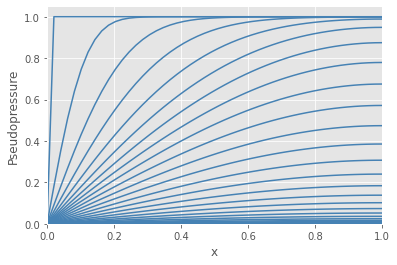

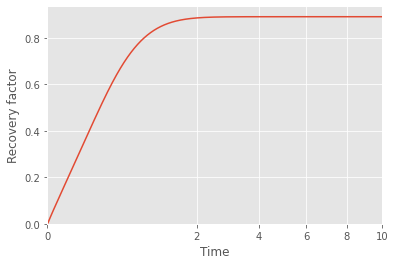

In [20]:

res_ideal = IdealReservoir(50, 1000, 9000, None)
%time res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()ax = plot_pseudopressure(res_ideal)

ax = plot_recovery_factor(res_ideal)
ax.set(xlabel="Time", ylabel="Recovery factor")

## Real gas simulation

        T      P  Z-Factor        Bg    Density        Cg  Viscosity  \
0     400      0  0.999577  0.294490   0.030003  0.068074   0.016332   
1     400     10  0.999291  0.175194   0.050433  0.040521   0.016333   
2     400     20  0.999006  0.124664   0.070874  0.028850   0.016333   
3     400     30  0.998724  0.096745   0.091327  0.022402   0.016334   
4     400     40  0.998443  0.079035   0.111791  0.018311   0.016335   
...   ...    ...       ...       ...        ...       ...        ...   
1196  400  11960  1.502527  0.000543  16.263662  0.000040   0.029418   
1197  400  11970  1.503177  0.000543  16.270207  0.000040   0.029430   
1198  400  11980  1.503827  0.000543  16.276745  0.000040   0.029441   
1199  400  11990  1.504476  0.000543  16.283278  0.000040   0.029452   
1200  400  12000  1.505126  0.000542  16.289804  0.000040   0.029464   

      pseudopressure  
0       0.000000e+00  
1       2.413310e+04  
2       6.052784e+04  
3       1.091900e+05  
4       1.701252e+05

<AxesSubplot:xlabel='pseudopressure', ylabel='diffusivity'>

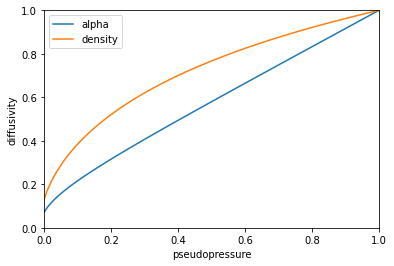

In [56]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")
print(pvt_gas)

def scale_pressure_diffusivity(df):
    out = df.assign(
        alpha=lambda x: 1/(x.Cg * x.Viscosity), 
        density=lambda x: x.Density/max(x.Density),
        pseudopressure=lambda x: (x["pseudopressure"] - x["pseudopressure"].min()) / 
            (x["pseudopressure"].max() - x["pseudopressure"].min()),
    ).assign(
        alpha=lambda x: x.alpha/x.alpha.iloc[-1]
    )[["P","pseudopressure", "alpha", "density"]]
    return out

fluid_properties = (
    pvt_gas[pvt_gas.P>=1000]
    .pipe(scale_pressure_diffusivity)
)
ax = fluid_properties.plot(x='pseudopressure', y="alpha")
ax.set(ylim=(0,1), xlim=(0,1), ylabel="diffusivity")
fluid_properties.plot(x="pseudopressure", y="density", ax=ax)




In [5]:
pvt_gas=pvt_gas.assign(m_scale=1/2*pvt_gas.Cg*pvt_gas.P*pvt_gas.Viscosity*pvt_gas['Z-Factor']/pvt_gas.P**2)
pvt_gas=pvt_gas.assign(m_initial_scaled=pvt_gas.pseudopressure*pvt_gas.m_scale)

In [6]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")
print(pvt_gas)

        T      P  Z-Factor        Bg    Density        Cg  Viscosity  \
0     400      0  0.999577  0.294490   0.030003  0.068074   0.016332   
1     400     10  0.999291  0.175194   0.050433  0.040521   0.016333   
2     400     20  0.999006  0.124664   0.070874  0.028850   0.016333   
3     400     30  0.998724  0.096745   0.091327  0.022402   0.016334   
4     400     40  0.998443  0.079035   0.111791  0.018311   0.016335   
...   ...    ...       ...       ...        ...       ...        ...   
1196  400  11960  1.502527  0.000543  16.263662  0.000040   0.029418   
1197  400  11970  1.503177  0.000543  16.270207  0.000040   0.029430   
1198  400  11980  1.503827  0.000543  16.276745  0.000040   0.029441   
1199  400  11990  1.504476  0.000543  16.283278  0.000040   0.029452   
1200  400  12000  1.505126  0.000542  16.289804  0.000040   0.029464   

      pseudopressure  
0       0.000000e+00  
1       2.413310e+04  
2       6.052784e+04  
3       1.091900e+05  
4       1.701252e+05

In [7]:
need_cols = {"pseudopressure","Cg","P","Viscosity","Z-Factor"}
need_cols.intersection(pvt_gas)
flow_properties = FlowPropertiesMarder(pvt_gas,12000)

In [154]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")
Pi=12000
Pf=3000
flow_properties = FlowPropertiesMarder(pvt_gas, Pi)

res_realgas = SinglePhaseReservoirMarder(100, Pf, Pi, flow_properties)

%time res_realgas.simulate(time)
rf2 = res_realgas.recovery_factor()



0.03907343285600884
CPU times: user 7.37 s, sys: 17.5 ms, total: 7.39 s
Wall time: 7.39 s


In [155]:
rf2

array([0.00000000e+00, 1.68327793e-07, 2.53362820e-06, ...,
       8.10970547e-01, 8.10970526e-01, 8.10970505e-01])

0.6229206434766663


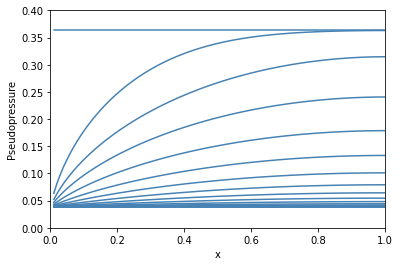

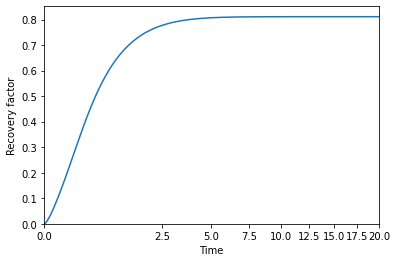

In [156]:
ax = plot_pseudopressure(res_realgas,xmax=1,mtop=.4)

ax = plot_recovery_factor(res_realgas)
ax.set(xlabel="Time", ylabel="Recovery factor")
#print(res_realgas.pseudopressure[:,0])
density_interp = interpolate.interp1d(fluid_properties["P"], fluid_properties["Density"])
print(1-density_interp(Pf)/density_interp(Pi))

# Flow Curves

In [62]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")

Pi=12000
rf={}
for Pf in np.linspace(1000,2000,2):
    print("Starting",Pf)
    fluid_properties = (
    pvt_gas[pvt_gas.P>=0]
    )
    #flow_properties = FlowProperties(fluid_properties, fvf_scale=0.3579)
    flow_properties = FlowPropertiesMarder(fluid_properties,Pi)

    res_realgas = SinglePhaseReservoirMarder(50, Pf, Pi, flow_properties)

    %time res_realgas.simulate(time)
    rf[Pf] = res_realgas.recovery_factor()
    

Starting 1000.0
0.004680354299527452
CPU times: user 6.06 s, sys: 12.5 ms, total: 6.07 s
Wall time: 6.07 s
Starting 2000.0
0.01810387320497186
CPU times: user 6.82 s, sys: 14.6 ms, total: 6.84 s
Wall time: 6.84 s


In [63]:
rf

{1000.0: array([ 0.00000000e+00,  1.22066681e-09,  1.95197121e-08, ...,
        -2.95542319e+00, -2.95632030e+00, -2.95676889e+00]),
 2000.0: array([ 0.00000000e+00,  1.07605092e-09,  1.74495477e-08, ...,
        -2.06291074e+01, -2.06353057e+01, -2.06384052e+01])}

In [54]:
fluid_properties

,T,P,Z-Factor,Bg,Density,Cg,Viscosity,pseudopressure
10,400,100,0.996798,0.037628,0.234810,0.008746,0.016341,7.937460e+05
11,400,110,0.996530,0.034601,0.255351,0.008046,0.016343,9.407256e+05
12,400,120,0.996264,0.032024,0.275903,0.007451,0.016344,1.100014e+06
13,400,130,0.995999,0.029803,0.296465,0.006937,0.016346,1.271613e+06
14,400,140,0.995737,0.027869,0.317037,0.006491,0.016347,1.455528e+06
...,...,...,...,...,...,...,...,...
1196,400,11960,1.502527,0.000543,16.263662,0.000040,0.029418,4.900670e+09
1197,400,11970,1.503177,0.000543,16.270207,0.000040,0.029430,4.906088e+09
1198,400,11980,1.503827,0.000543,16.276745,0.000040,0.029441,4.911506e+09
1199,400,11990,1.504476,0.000543,16.283278,0.000040,0.029452,4.916925e+09


Reservoir density is 16.2898040359229  and bottom density is 2.11203367322722
Reservoir density is 16.2898040359229  and bottom density is 2.63680578183981
Reservoir density is 16.2898040359229  and bottom density is 3.15916562268714
Reservoir density is 16.2898040359229  and bottom density is 3.67710448991346
Reservoir density is 16.2898040359229  and bottom density is 4.18875425405911


[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovered gas'),
 (0.0, 0.06459956729242114),
 None,
 (0.0, 21.000000000000004)]

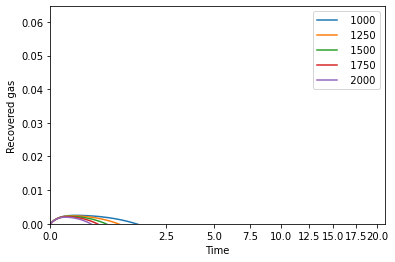

In [55]:
from scipy import interpolate
fluid_properties = (
    pvt_gas[pvt_gas.P>=100]
    )
density_interp = interpolate.interp1d(fluid_properties["P"], fluid_properties["Density"])

fig = plt.figure(figsize=(6,4))
ax = plt.axes()
for key in rf.keys():
    print("Reservoir density is",density_interp(Pi)," and bottom density is",density_interp(key))
    ax.plot(time,rf[key]/(density_interp(Pi)-density_interp(key)),label=" {:5.0f}".format(key))
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))


In [47]:
k=list(rf.keys())[9]
rf[k]/(density_interp(Pi)-density_interp(k))

array([0.00000000e+00, 7.08141032e-06, 2.82985179e-05, ...,
       1.03800299e+00, 1.03800342e+00, 1.03800384e+00])

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovery factor'),
 (0.0, 0.9352331895079818),
 None,
 (0.0, 6.299999999999999)]

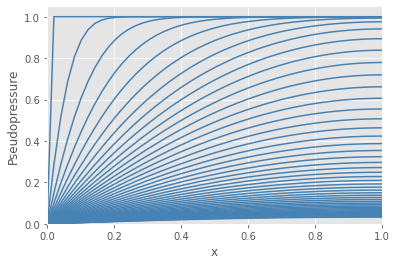

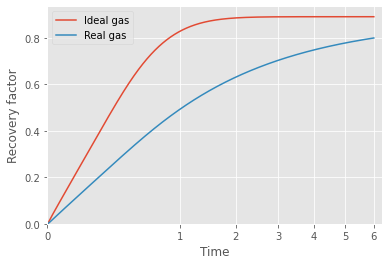

In [8]:
ax = plot_pseudopressure(res_realgas)

fig, ax = plt.subplots()
ax.plot(time, rf_ideal, label="Ideal gas")
ax.plot(time, rf2, label="Real gas")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovery factor", ylim=(0,None), xscale='squareroot', xlim=(0,None))